In [1]:
import os
import torch
from trainer import Trainer

from Preprocessing import (
    filter_collate_fn,
    generate_file_path,
    get_train_transform,
    get_validation_transform
)

from monai.data import (
    DataLoader,
    ThreadDataLoader,
    SmartCacheDataset,
    PersistentDataset,
    load_decathlon_datalist,
    decollate_batch,
    set_track_meta,
)

from monai.losses import DiceCELoss

from monai.networks.nets import SwinUNETR
from map_to_binary import class_map_5_parts
from monai.data.utils import pad_list_data_collate


MONAI version: 1.2.dev2313
Numpy version: 1.23.5
Pytorch version: 2.0.0+cu118
MONAI flags: HAS_EXT = False, USE_COMPILED = False, USE_META_DICT = False
MONAI rev id: 331437dfce075b4fa5785016ad4e7f8c7c77ad21
MONAI __file__: D:\Arash\Semester2\DeepLearning\FinalProject\venv\lib\site-packages\monai\__init__.py

Optional dependencies:
Pytorch Ignite version: 0.4.11
ITK version: 5.3.0
Nibabel version: 5.0.1
scikit-image version: 0.20.0
Pillow version: 9.4.0
Tensorboard version: 2.12.0
gdown version: 4.7.1
TorchVision version: 0.15.1+cu118
tqdm version: 4.65.0
lmdb version: 1.4.0
psutil version: 5.9.4
pandas version: 1.5.3
einops version: 0.6.0
transformers version: 4.27.3
mlflow version: 2.2.2
pynrrd version: 1.0.0

For details about installing the optional dependencies, please visit:
    https://docs.monai.io/en/latest/installation.html#installing-the-recommended-dependencies



In [2]:
task_name = 'vertebrae'
val_transforms = get_validation_transform()
train_transforms = get_train_transform(num_samples=4)

# Load Dataset

In [3]:
root_dataset = 'DatasetCombined'
label_name = f'labels_task_{task_name}'

In [ ]:
file_list_val = generate_file_path(root_path=f'{root_dataset}/val', label_name=label_name)
file_list_train = generate_file_path(root_path=f'{root_dataset}/train', label_name=label_name)

In [5]:
train_ds = PersistentDataset(
    data=file_list_train,
    transform=train_transforms,
    cache_dir=f'C:/Training/train_{task_name}'
)

train_loader = ThreadDataLoader(train_ds, batch_size=1, shuffle=True,
                                collate_fn=lambda x: pad_list_data_collate(x, pad_to_shape=(96, 96, 96))
                               )

In [6]:
val_ds = PersistentDataset(
    data=file_list_val,
    transform=val_transforms,
    cache_dir=f'val_{task_name}'
#     cache_dir='C:/Training/val'
)

val_loader = DataLoader(val_ds, batch_size=1, num_workers=0,
                              collate_fn=lambda x: pad_list_data_collate(x, pad_to_shape=(96, 96, 96)))

In [4]:
num_of_classes = len(class_map_5_parts[f'class_map_part_{task_name}']) + 1
num_of_classes

25

# Model

In [5]:
root_dir = 'Model'
model_folder = os.path.join(root_dir, f'SwinTransformer_{task_name}')
if not os.path.isdir(model_folder):
    os.makedirs(model_folder)

In [6]:
model = SwinUNETR(
    img_size=(96, 96, 96),
    in_channels=1,
    out_channels=num_of_classes,
    feature_size=48,
#     drop_rate=0.25,
    use_checkpoint=True,
)

In [7]:
loss_function = DiceCELoss(to_onehot_y=True, softmax=True, lambda_dice=1, lambda_ce=1)
optimizer = torch.optim.AdamW(model.parameters(), lr=1e-4, weight_decay=1e-5)

In [8]:
swin_trainer = Trainer(
    model=model,
    max_epoch=1000,
    optimizer=optimizer,
    num_samples=4,
    loss_function=loss_function,
    model_root_path=model_folder,
    number_of_classes=num_of_classes,
    )
swin_trainer.load_weights()

In [12]:
torch.backends.cudnn.benchmark = True
swin_trainer.train(train_loader, val_loader)

Validate (loss=1.04182): 100%|█████████████████████████████████████████████████████████| 55/55 [02:54<00:00,  3.18s/it]


Mean Hausdorff disatnce: 0
Model Was Saved ! Current Best Avg. Dice: 0.03166110813617706 Current Avg. Dice: 0.03166110813617706


Validate (loss=0.94803): 100%|█████████████████████████████████████████████████████████| 55/55 [02:49<00:00,  3.08s/it]


Mean Hausdorff disatnce: 0
Model Was Saved ! Current Best Avg. Dice: 0.167502298951149 Current Avg. Dice: 0.167502298951149


Validate (loss=0.91206): 100%|█████████████████████████████████████████████████████████| 55/55 [02:51<00:00,  3.11s/it]


Mean Hausdorff disatnce: 0
Model Was Saved ! Current Best Avg. Dice: 0.2578611671924591 Current Avg. Dice: 0.2578611671924591


Validate (loss=0.80049): 100%|█████████████████████████████████████████████████████████| 55/55 [02:47<00:00,  3.05s/it]


Mean Hausdorff disatnce: 0
Model Was Saved ! Current Best Avg. Dice: 0.42884930968284607 Current Avg. Dice: 0.42884930968284607


Validate (loss=0.71754): 100%|█████████████████████████████████████████████████████████| 55/55 [02:47<00:00,  3.04s/it]


Mean Hausdorff disatnce: 0
Model Was Saved ! Current Best Avg. Dice: 0.46943724155426025 Current Avg. Dice: 0.46943724155426025


Validate (loss=0.71770): 100%|█████████████████████████████████████████████████████████| 55/55 [02:49<00:00,  3.09s/it]


Mean Hausdorff disatnce: 0
Model Was Saved ! Current Best Avg. Dice: 0.5597102046012878 Current Avg. Dice: 0.5597102046012878


Validate (loss=0.65689): 100%|█████████████████████████████████████████████████████████| 55/55 [02:47<00:00,  3.05s/it]


Mean Hausdorff disatnce: 0
Model Was Saved ! Current Best Avg. Dice: 0.6168116927146912 Current Avg. Dice: 0.6168116927146912


Validate (loss=0.58831): 100%|█████████████████████████████████████████████████████████| 55/55 [02:47<00:00,  3.04s/it]


Mean Hausdorff disatnce: 0
Model Was Not Saved ! Current Best Avg. Dice: 0.6168116927146912 Current Avg. Dice: 0.6160589456558228


Validate (loss=0.60977): 100%|█████████████████████████████████████████████████████████| 55/55 [02:48<00:00,  3.06s/it]


Mean Hausdorff disatnce: 0
Model Was Saved ! Current Best Avg. Dice: 0.6447648406028748 Current Avg. Dice: 0.6447648406028748


Validate (loss=0.55205): 100%|█████████████████████████████████████████████████████████| 55/55 [02:46<00:00,  3.03s/it]


Mean Hausdorff disatnce: 0
Model Was Saved ! Current Best Avg. Dice: 0.6655867099761963 Current Avg. Dice: 0.6655867099761963


Validate (loss=0.61649): 100%|█████████████████████████████████████████████████████████| 55/55 [02:50<00:00,  3.10s/it]


Early Stopping patience: 1, best loss: 0.6696494498036124, current_loss: 0.6817383511499925
Mean Hausdorff disatnce: 0
Model Was Not Saved ! Current Best Avg. Dice: 0.6655867099761963 Current Avg. Dice: 0.6121068596839905


Validate (loss=0.51215): 100%|█████████████████████████████████████████████████████████| 55/55 [02:48<00:00,  3.05s/it]


Mean Hausdorff disatnce: 0
Model Was Saved ! Current Best Avg. Dice: 0.7250441312789917 Current Avg. Dice: 0.7250441312789917


Validate (loss=0.60784): 100%|█████████████████████████████████████████████████████████| 55/55 [02:47<00:00,  3.04s/it]


Early Stopping patience: 1, best loss: 0.6259749818931927, current_loss: 0.643668503111059
Mean Hausdorff disatnce: 0
Model Was Not Saved ! Current Best Avg. Dice: 0.7250441312789917 Current Avg. Dice: 0.682146430015564


Validate (loss=0.54891): 100%|█████████████████████████████████████████████████████████| 55/55 [02:47<00:00,  3.04s/it]


Early Stopping patience: 2, best loss: 0.6259749818931927, current_loss: 0.6270314986055547
Mean Hausdorff disatnce: 0
Model Was Not Saved ! Current Best Avg. Dice: 0.7250441312789917 Current Avg. Dice: 0.7118619084358215


Validate (loss=0.48967): 100%|█████████████████████████████████████████████████████████| 55/55 [02:47<00:00,  3.04s/it]


Mean Hausdorff disatnce: 0
Model Was Saved ! Current Best Avg. Dice: 0.7353171110153198 Current Avg. Dice: 0.7353171110153198


Validate (loss=0.43996): 100%|█████████████████████████████████████████████████████████| 55/55 [02:49<00:00,  3.07s/it]


Mean Hausdorff disatnce: 0
Model Was Saved ! Current Best Avg. Dice: 0.7545052766799927 Current Avg. Dice: 0.7545052766799927


Validate (loss=0.46797): 100%|█████████████████████████████████████████████████████████| 55/55 [02:47<00:00,  3.04s/it]


Early Stopping patience: 1, best loss: 0.5997018413110213, current_loss: 0.6225576660849831
Mean Hausdorff disatnce: 0
Model Was Not Saved ! Current Best Avg. Dice: 0.7545052766799927 Current Avg. Dice: 0.7114744782447815


Validate (loss=0.43575): 100%|█████████████████████████████████████████████████████████| 55/55 [02:49<00:00,  3.08s/it]


Mean Hausdorff disatnce: 0
Model Was Saved ! Current Best Avg. Dice: 0.7604602575302124 Current Avg. Dice: 0.7604602575302124


Validate (loss=0.44201): 100%|█████████████████████████████████████████████████████████| 55/55 [02:48<00:00,  3.06s/it]


Mean Hausdorff disatnce: 0
Model Was Saved ! Current Best Avg. Dice: 0.7660107612609863 Current Avg. Dice: 0.7660107612609863


Validate (loss=0.44359): 100%|█████████████████████████████████████████████████████████| 55/55 [02:47<00:00,  3.05s/it]


Early Stopping patience: 1, best loss: 0.5848384277387099, current_loss: 0.6111163767901334
Mean Hausdorff disatnce: 0
Model Was Not Saved ! Current Best Avg. Dice: 0.7660107612609863 Current Avg. Dice: 0.7177063822746277


Validate (loss=0.43630): 100%|█████████████████████████████████████████████████████████| 55/55 [02:48<00:00,  3.07s/it]


Early Stopping patience: 2, best loss: 0.5848384277387099, current_loss: 0.5873408805240284
Mean Hausdorff disatnce: 0
Model Was Not Saved ! Current Best Avg. Dice: 0.7660107612609863 Current Avg. Dice: 0.7604016661643982


Validate (loss=0.41703): 100%|█████████████████████████████████████████████████████████| 55/55 [02:49<00:00,  3.09s/it]


Mean Hausdorff disatnce: 0
Model Was Saved ! Current Best Avg. Dice: 0.7735209465026855 Current Avg. Dice: 0.7735209465026855


Validate (loss=0.44574): 100%|█████████████████████████████████████████████████████████| 55/55 [02:48<00:00,  3.06s/it]


Early Stopping patience: 1, best loss: 0.5750849902629852, current_loss: 0.5892601723020727
Mean Hausdorff disatnce: 0
Model Was Not Saved ! Current Best Avg. Dice: 0.7735209465026855 Current Avg. Dice: 0.7520115375518799


Validate (loss=0.39752): 100%|█████████████████████████████████████████████████████████| 55/55 [02:49<00:00,  3.08s/it]


Mean Hausdorff disatnce: 0
Model Was Saved ! Current Best Avg. Dice: 0.7813552021980286 Current Avg. Dice: 0.7813552021980286


Validate (loss=0.41481): 100%|█████████████████████████████████████████████████████████| 55/55 [02:48<00:00,  3.06s/it]


Early Stopping patience: 1, best loss: 0.5656046135859056, current_loss: 0.5689128967848691
Mean Hausdorff disatnce: 0
Model Was Saved ! Current Best Avg. Dice: 0.7815419435501099 Current Avg. Dice: 0.7815419435501099


Validate (loss=0.43553): 100%|█████████████████████████████████████████████████████████| 55/55 [02:48<00:00,  3.07s/it]


Early Stopping patience: 2, best loss: 0.5656046135859056, current_loss: 0.5687814289873296
Mean Hausdorff disatnce: 0
Model Was Not Saved ! Current Best Avg. Dice: 0.7815419435501099 Current Avg. Dice: 0.7753771543502808


Validate (loss=0.40650): 100%|█████████████████████████████████████████████████████████| 55/55 [02:47<00:00,  3.05s/it]


Mean Hausdorff disatnce: 0
Model Was Saved ! Current Best Avg. Dice: 0.8000150918960571 Current Avg. Dice: 0.8000150918960571


Validate (loss=0.40823): 100%|█████████████████████████████████████████████████████████| 55/55 [02:48<00:00,  3.06s/it]


Early Stopping patience: 1, best loss: 0.5552085036581212, current_loss: 0.5625436931848526
Mean Hausdorff disatnce: 0
Model Was Not Saved ! Current Best Avg. Dice: 0.8000150918960571 Current Avg. Dice: 0.7942613363265991


Validate (loss=0.39509): 100%|█████████████████████████████████████████████████████████| 55/55 [02:48<00:00,  3.06s/it]


Early Stopping patience: 2, best loss: 0.5552085036581212, current_loss: 0.5978309747847643
Mean Hausdorff disatnce: 0
Model Was Not Saved ! Current Best Avg. Dice: 0.8000150918960571 Current Avg. Dice: 0.7252845764160156


Validate (loss=0.40215): 100%|█████████████████████████████████████████████████████████| 55/55 [02:49<00:00,  3.08s/it]


Early Stopping patience: 3, best loss: 0.5552085036581212, current_loss: 0.5682345831936056
Mean Hausdorff disatnce: 0
Model Was Not Saved ! Current Best Avg. Dice: 0.8000150918960571 Current Avg. Dice: 0.7683638334274292


Validate (loss=0.39844): 100%|█████████████████████████████████████████████████████████| 55/55 [02:49<00:00,  3.08s/it]


Mean Hausdorff disatnce: 0
Model Was Saved ! Current Best Avg. Dice: 0.8042580485343933 Current Avg. Dice: 0.8042580485343933


Validate (loss=0.38646): 100%|█████████████████████████████████████████████████████████| 55/55 [02:49<00:00,  3.08s/it]


Mean Hausdorff disatnce: 0
Model Was Saved ! Current Best Avg. Dice: 0.8077713251113892 Current Avg. Dice: 0.8077713251113892


Validate (loss=0.39069): 100%|█████████████████████████████████████████████████████████| 55/55 [02:48<00:00,  3.06s/it]


Early Stopping patience: 1, best loss: 0.5502313524484634, current_loss: 0.5495303145863794
Mean Hausdorff disatnce: 0
Model Was Saved ! Current Best Avg. Dice: 0.807919442653656 Current Avg. Dice: 0.807919442653656


Validate (loss=0.39295): 100%|█████████████████████████████████████████████████████████| 55/55 [02:47<00:00,  3.05s/it]


Early Stopping patience: 2, best loss: 0.5502313524484634, current_loss: 0.5570732826536352
Mean Hausdorff disatnce: 0
Model Was Not Saved ! Current Best Avg. Dice: 0.807919442653656 Current Avg. Dice: 0.797482430934906


Validate (loss=0.39897): 100%|█████████████████████████████████████████████████████████| 55/55 [02:47<00:00,  3.05s/it]


Early Stopping patience: 3, best loss: 0.5502313524484634, current_loss: 0.5597981409593062
Mean Hausdorff disatnce: 0
Model Was Not Saved ! Current Best Avg. Dice: 0.807919442653656 Current Avg. Dice: 0.782487154006958


Validate (loss=0.43765): 100%|█████████████████████████████████████████████████████████| 55/55 [02:50<00:00,  3.10s/it]


Early Stopping patience: 4, best loss: 0.5502313524484634, current_loss: 0.579203060540286
Mean Hausdorff disatnce: 0
Model Was Not Saved ! Current Best Avg. Dice: 0.807919442653656 Current Avg. Dice: 0.7553590536117554


Validate (loss=0.37841): 100%|█████████████████████████████████████████████████████████| 55/55 [02:47<00:00,  3.05s/it]


Mean Hausdorff disatnce: 0
Model Was Saved ! Current Best Avg. Dice: 0.8232340216636658 Current Avg. Dice: 0.8232340216636658


Validate (loss=0.38648): 100%|█████████████████████████████████████████████████████████| 55/55 [02:47<00:00,  3.05s/it]


Early Stopping patience: 1, best loss: 0.5402789798649874, current_loss: 0.5467173625122417
Mean Hausdorff disatnce: 0
Model Was Not Saved ! Current Best Avg. Dice: 0.8232340216636658 Current Avg. Dice: 0.8057832717895508


Validate (loss=0.37373): 100%|█████████████████████████████████████████████████████████| 55/55 [02:47<00:00,  3.05s/it]


Early Stopping patience: 2, best loss: 0.5402789798649874, current_loss: 0.547142522985285
Mean Hausdorff disatnce: 0
Model Was Not Saved ! Current Best Avg. Dice: 0.8232340216636658 Current Avg. Dice: 0.8043937087059021


Validate (loss=0.39858): 100%|█████████████████████████████████████████████████████████| 55/55 [02:47<00:00,  3.05s/it]


Early Stopping patience: 3, best loss: 0.5402789798649874, current_loss: 0.5565334851091558
Mean Hausdorff disatnce: 0
Model Was Not Saved ! Current Best Avg. Dice: 0.8232340216636658 Current Avg. Dice: 0.7902685403823853


Validate (loss=0.36110): 100%|█████████████████████████████████████████████████████████| 55/55 [02:48<00:00,  3.07s/it]


Mean Hausdorff disatnce: 0
Model Was Not Saved ! Current Best Avg. Dice: 0.8232340216636658 Current Avg. Dice: 0.8184933662414551


Validate (loss=0.36366): 100%|█████████████████████████████████████████████████████████| 55/55 [02:47<00:00,  3.05s/it]


Early Stopping patience: 1, best loss: 0.5372641547159716, current_loss: 0.5376056749712337
Mean Hausdorff disatnce: 0
Model Was Saved ! Current Best Avg. Dice: 0.8290935158729553 Current Avg. Dice: 0.8290935158729553


Validate (loss=0.37046): 100%|█████████████████████████████████████████████████████████| 55/55 [02:47<00:00,  3.04s/it]


Mean Hausdorff disatnce: 0
Model Was Saved ! Current Best Avg. Dice: 0.833643913269043 Current Avg. Dice: 0.833643913269043


Validate (loss=0.36437): 100%|█████████████████████████████████████████████████████████| 55/55 [02:48<00:00,  3.06s/it]


Early Stopping patience: 1, best loss: 0.5311372602527792, current_loss: 0.5308900708501989
Mean Hausdorff disatnce: 0
Model Was Saved ! Current Best Avg. Dice: 0.8347760438919067 Current Avg. Dice: 0.8347760438919067


Validate (loss=0.37978): 100%|█████████████████████████████████████████████████████████| 55/55 [02:48<00:00,  3.06s/it]


Early Stopping patience: 2, best loss: 0.5311372602527792, current_loss: 0.544393743168224
Mean Hausdorff disatnce: 0
Model Was Not Saved ! Current Best Avg. Dice: 0.8347760438919067 Current Avg. Dice: 0.8119340538978577


Validate (loss=0.38212): 100%|█████████████████████████████████████████████████████████| 55/55 [02:48<00:00,  3.06s/it]


Early Stopping patience: 3, best loss: 0.5311372602527792, current_loss: 0.5419254140420393
Mean Hausdorff disatnce: 0
Model Was Not Saved ! Current Best Avg. Dice: 0.8347760438919067 Current Avg. Dice: 0.8131582140922546


Validate (loss=0.36037): 100%|█████████████████████████████████████████████████████████| 55/55 [02:48<00:00,  3.07s/it]


Mean Hausdorff disatnce: 0
Model Was Saved ! Current Best Avg. Dice: 0.8388802409172058 Current Avg. Dice: 0.8388802409172058


Validate (loss=0.38171): 100%|█████████████████████████████████████████████████████████| 55/55 [02:49<00:00,  3.08s/it]


Early Stopping patience: 1, best loss: 0.5300776462663304, current_loss: 0.5359070588241924
Mean Hausdorff disatnce: 0
Model Was Not Saved ! Current Best Avg. Dice: 0.8388802409172058 Current Avg. Dice: 0.8179526329040527


Validate (loss=0.36666): 100%|█████████████████████████████████████████████████████████| 55/55 [02:47<00:00,  3.04s/it]


Early Stopping patience: 2, best loss: 0.5300776462663304, current_loss: 0.531109331683679
Mean Hausdorff disatnce: 0
Model Was Not Saved ! Current Best Avg. Dice: 0.8388802409172058 Current Avg. Dice: 0.8320779204368591


Validate (loss=0.36188): 100%|█████████████████████████████████████████████████████████| 55/55 [02:49<00:00,  3.08s/it]


Mean Hausdorff disatnce: 0
Model Was Saved ! Current Best Avg. Dice: 0.8410128355026245 Current Avg. Dice: 0.8410128355026245


Validate (loss=0.36226): 100%|█████████████████████████████████████████████████████████| 55/55 [02:48<00:00,  3.07s/it]


Early Stopping patience: 1, best loss: 0.5265608538280834, current_loss: 0.5337281468239697
Mean Hausdorff disatnce: 0
Model Was Not Saved ! Current Best Avg. Dice: 0.8410128355026245 Current Avg. Dice: 0.8275554776191711


Validate (loss=0.37755): 100%|█████████████████████████████████████████████████████████| 55/55 [02:48<00:00,  3.06s/it]


Early Stopping patience: 2, best loss: 0.5265608538280834, current_loss: 0.5332804980603132
Mean Hausdorff disatnce: 0
Model Was Not Saved ! Current Best Avg. Dice: 0.8410128355026245 Current Avg. Dice: 0.8374891877174377


Validate (loss=0.35870): 100%|█████████████████████████████████████████████████████████| 55/55 [02:49<00:00,  3.08s/it]


Early Stopping patience: 3, best loss: 0.5265608538280834, current_loss: 0.5324482037262483
Mean Hausdorff disatnce: 0
Model Was Not Saved ! Current Best Avg. Dice: 0.8410128355026245 Current Avg. Dice: 0.827890157699585


Validate (loss=0.39164): 100%|█████████████████████████████████████████████████████████| 55/55 [02:48<00:00,  3.06s/it]


Epoch 00054: reducing learning rate of group 0 to 2.5000e-05.
Early Stopping patience: 4, best loss: 0.5265608538280834, current_loss: 0.5323334788734263
Mean Hausdorff disatnce: 0
Model Was Not Saved ! Current Best Avg. Dice: 0.8410128355026245 Current Avg. Dice: 0.8234320282936096


Validate (loss=0.35788): 100%|█████████████████████████████████████████████████████████| 55/55 [02:47<00:00,  3.05s/it]


Mean Hausdorff disatnce: 0
Model Was Saved ! Current Best Avg. Dice: 0.8535689115524292 Current Avg. Dice: 0.8535689115524292


Validate (loss=0.35329): 100%|█████████████████████████████████████████████████████████| 55/55 [02:49<00:00,  3.07s/it]


Early Stopping patience: 1, best loss: 0.514646809480407, current_loss: 0.5177600465037606
Mean Hausdorff disatnce: 0
Model Was Not Saved ! Current Best Avg. Dice: 0.8535689115524292 Current Avg. Dice: 0.8502793908119202


Validate (loss=0.35723): 100%|█████████████████████████████████████████████████████████| 55/55 [02:49<00:00,  3.08s/it]


Early Stopping patience: 2, best loss: 0.514646809480407, current_loss: 0.5144740129059011
Mean Hausdorff disatnce: 0
Model Was Saved ! Current Best Avg. Dice: 0.8535751104354858 Current Avg. Dice: 0.8535751104354858


Validate (loss=0.35662): 100%|█████████████████████████████████████████████████████████| 55/55 [02:47<00:00,  3.04s/it]


Mean Hausdorff disatnce: 0
Model Was Saved ! Current Best Avg. Dice: 0.8592594265937805 Current Avg. Dice: 0.8592594265937805


Validate (loss=0.35215): 100%|█████████████████████████████████████████████████████████| 55/55 [02:47<00:00,  3.05s/it]


Early Stopping patience: 1, best loss: 0.5118912642652338, current_loss: 0.5145951000126925
Mean Hausdorff disatnce: 0
Model Was Not Saved ! Current Best Avg. Dice: 0.8592594265937805 Current Avg. Dice: 0.8512603640556335


Validate (loss=0.35040): 100%|█████████████████████████████████████████████████████████| 55/55 [02:49<00:00,  3.08s/it]


Mean Hausdorff disatnce: 0
Model Was Not Saved ! Current Best Avg. Dice: 0.8592594265937805 Current Avg. Dice: 0.7641960978507996


Validate (loss=0.27654): 100%|█████████████████████████████████████████████████████████| 55/55 [02:49<00:00,  3.08s/it]


Mean Hausdorff disatnce: 0
Model Was Not Saved ! Current Best Avg. Dice: 0.8592594265937805 Current Avg. Dice: 0.7496150732040405


Validate (loss=0.25195): 100%|█████████████████████████████████████████████████████████| 55/55 [02:49<00:00,  3.08s/it]


Mean Hausdorff disatnce: 0
Model Was Not Saved ! Current Best Avg. Dice: 0.8592594265937805 Current Avg. Dice: 0.7569559216499329


Validate (loss=0.22648): 100%|█████████████████████████████████████████████████████████| 55/55 [02:47<00:00,  3.05s/it]


Mean Hausdorff disatnce: 0
Model Was Not Saved ! Current Best Avg. Dice: 0.8592594265937805 Current Avg. Dice: 0.7483606338500977


Validate (loss=0.22201): 100%|█████████████████████████████████████████████████████████| 55/55 [02:47<00:00,  3.04s/it]


Mean Hausdorff disatnce: 0
Model Was Not Saved ! Current Best Avg. Dice: 0.8592594265937805 Current Avg. Dice: 0.7627918124198914


Validate (loss=0.20412): 100%|█████████████████████████████████████████████████████████| 55/55 [02:49<00:00,  3.09s/it]


Mean Hausdorff disatnce: 0
Model Was Not Saved ! Current Best Avg. Dice: 0.8592594265937805 Current Avg. Dice: 0.7915496826171875


Validate (loss=0.19524): 100%|█████████████████████████████████████████████████████████| 55/55 [02:49<00:00,  3.08s/it]


Mean Hausdorff disatnce: 0
Model Was Not Saved ! Current Best Avg. Dice: 0.8592594265937805 Current Avg. Dice: 0.7857996225357056


Validate (loss=0.17967): 100%|█████████████████████████████████████████████████████████| 55/55 [02:48<00:00,  3.06s/it]


Mean Hausdorff disatnce: 0
Model Was Not Saved ! Current Best Avg. Dice: 0.8592594265937805 Current Avg. Dice: 0.8064724206924438


Validate (loss=0.15648): 100%|█████████████████████████████████████████████████████████| 55/55 [02:47<00:00,  3.05s/it]


Mean Hausdorff disatnce: 0
Model Was Not Saved ! Current Best Avg. Dice: 0.8592594265937805 Current Avg. Dice: 0.8067231774330139


Validate (loss=0.12100): 100%|█████████████████████████████████████████████████████████| 55/55 [02:49<00:00,  3.07s/it]


Mean Hausdorff disatnce: 0
Model Was Not Saved ! Current Best Avg. Dice: 0.8592594265937805 Current Avg. Dice: 0.8103796243667603


Validate (loss=0.09764): 100%|█████████████████████████████████████████████████████████| 55/55 [02:48<00:00,  3.06s/it]


Mean Hausdorff disatnce: 0
Model Was Not Saved ! Current Best Avg. Dice: 0.8592594265937805 Current Avg. Dice: 0.8172086477279663


Validate (loss=0.09025): 100%|█████████████████████████████████████████████████████████| 55/55 [02:49<00:00,  3.08s/it]


Mean Hausdorff disatnce: 0
Model Was Not Saved ! Current Best Avg. Dice: 0.8592594265937805 Current Avg. Dice: 0.8231269717216492


Validate (loss=0.10042): 100%|█████████████████████████████████████████████████████████| 55/55 [02:47<00:00,  3.05s/it]


Early Stopping patience: 1, best loss: 0.14198089160702446, current_loss: 0.1470928591760722
Mean Hausdorff disatnce: 0
Model Was Not Saved ! Current Best Avg. Dice: 0.8592594265937805 Current Avg. Dice: 0.8105677962303162


Validate (loss=0.09763): 100%|█████████████████████████████████████████████████████████| 55/55 [02:48<00:00,  3.06s/it]


Mean Hausdorff disatnce: 0
Model Was Not Saved ! Current Best Avg. Dice: 0.8592594265937805 Current Avg. Dice: 0.8232899308204651


Validate (loss=0.09759): 100%|█████████████████████████████████████████████████████████| 55/55 [02:49<00:00,  3.07s/it]


Mean Hausdorff disatnce: 0
Model Was Not Saved ! Current Best Avg. Dice: 0.8592594265937805 Current Avg. Dice: 0.8229753375053406


Validate (loss=0.09074): 100%|█████████████████████████████████████████████████████████| 55/55 [02:47<00:00,  3.05s/it]


Early Stopping patience: 1, best loss: 0.135347899726846, current_loss: 0.13516372137449004
Mean Hausdorff disatnce: 0
Model Was Not Saved ! Current Best Avg. Dice: 0.8592594265937805 Current Avg. Dice: 0.8178638219833374


Validate (loss=0.08271): 100%|█████████████████████████████████████████████████████████| 55/55 [02:49<00:00,  3.09s/it]


Mean Hausdorff disatnce: 0
Model Was Not Saved ! Current Best Avg. Dice: 0.8592594265937805 Current Avg. Dice: 0.828734815120697


Validate (loss=0.07575): 100%|█████████████████████████████████████████████████████████| 55/55 [02:48<00:00,  3.05s/it]


Early Stopping patience: 1, best loss: 0.1269590969451449, current_loss: 0.12652843225408683
Mean Hausdorff disatnce: 0
Model Was Not Saved ! Current Best Avg. Dice: 0.8592594265937805 Current Avg. Dice: 0.8255552649497986


Validate (loss=0.06727): 100%|█████████████████████████████████████████████████████████| 55/55 [03:10<00:00,  3.47s/it]


Mean Hausdorff disatnce: 0
Model Was Not Saved ! Current Best Avg. Dice: 0.8592594265937805 Current Avg. Dice: 0.8314730525016785


Validate (loss=0.06766): 100%|█████████████████████████████████████████████████████████| 55/55 [03:07<00:00,  3.41s/it]


Mean Hausdorff disatnce: 0
Model Was Not Saved ! Current Best Avg. Dice: 0.8592594265937805 Current Avg. Dice: 0.8349608182907104


Validate (loss=0.06691): 100%|█████████████████████████████████████████████████████████| 55/55 [03:07<00:00,  3.41s/it]


Early Stopping patience: 1, best loss: 0.11960587405006994, current_loss: 0.1269437121904709
Mean Hausdorff disatnce: 0
Model Was Not Saved ! Current Best Avg. Dice: 0.8592594265937805 Current Avg. Dice: 0.822494387626648


Validate (loss=0.06437): 100%|█████████████████████████████████████████████████████████| 55/55 [03:49<00:00,  4.18s/it]


Early Stopping patience: 2, best loss: 0.11960587405006994, current_loss: 0.12521013170480727
Mean Hausdorff disatnce: 0
Model Was Not Saved ! Current Best Avg. Dice: 0.8592594265937805 Current Avg. Dice: 0.8274049162864685


Validate (loss=0.06659): 100%|█████████████████████████████████████████████████████████| 55/55 [03:06<00:00,  3.38s/it]


Early Stopping patience: 3, best loss: 0.11960587405006994, current_loss: 0.12329776317558505
Mean Hausdorff disatnce: 0
Model Was Not Saved ! Current Best Avg. Dice: 0.8592594265937805 Current Avg. Dice: 0.8282223343849182


Validate (loss=0.04297): 100%|█████████████████████████████████████████████████████████| 55/55 [02:57<00:00,  3.22s/it]


Epoch 00083: reducing learning rate of group 0 to 6.2500e-06.
Early Stopping patience: 4, best loss: 0.11960587405006994, current_loss: 0.12003453058952634
Mean Hausdorff disatnce: 0
Model Was Not Saved ! Current Best Avg. Dice: 0.8592594265937805 Current Avg. Dice: 0.829456627368927


Validate (loss=0.04218): 100%|█████████████████████████████████████████████████████████| 55/55 [02:52<00:00,  3.14s/it]


Mean Hausdorff disatnce: 0
Model Was Not Saved ! Current Best Avg. Dice: 0.8592594265937805 Current Avg. Dice: 0.8407043218612671


Validate (loss=0.03946): 100%|█████████████████████████████████████████████████████████| 55/55 [02:52<00:00,  3.13s/it]


Early Stopping patience: 1, best loss: 0.11230030799792572, current_loss: 0.1132878061553294
Mean Hausdorff disatnce: 0
Model Was Not Saved ! Current Best Avg. Dice: 0.8592594265937805 Current Avg. Dice: 0.8384602069854736


Validate (loss=0.03697): 100%|█████████████████████████████████████████████████████████| 55/55 [02:48<00:00,  3.07s/it]


Early Stopping patience: 2, best loss: 0.11230030799792572, current_loss: 0.11332648106935349
Mean Hausdorff disatnce: 0
Model Was Not Saved ! Current Best Avg. Dice: 0.8592594265937805 Current Avg. Dice: 0.8373581171035767


Validate (loss=0.03659): 100%|█████████████████████████████████████████████████████████| 55/55 [02:47<00:00,  3.05s/it]


Early Stopping patience: 3, best loss: 0.11230030799792572, current_loss: 0.11432909648865461
Mean Hausdorff disatnce: 0
Model Was Not Saved ! Current Best Avg. Dice: 0.8592594265937805 Current Avg. Dice: 0.8379414081573486


Validate (loss=0.03704): 100%|█████████████████████████████████████████████████████████| 55/55 [02:50<00:00,  3.09s/it]


Epoch 00088: reducing learning rate of group 0 to 1.5625e-06.
Early Stopping patience: 4, best loss: 0.11230030799792572, current_loss: 0.11294956278394569
Mean Hausdorff disatnce: 0
Model Was Not Saved ! Current Best Avg. Dice: 0.8592594265937805 Current Avg. Dice: 0.8400755524635315


Validate (loss=0.03632): 100%|█████████████████████████████████████████████████████████| 55/55 [02:47<00:00,  3.05s/it]


Early Stopping patience: 5, best loss: 0.11230030799792572, current_loss: 0.11159908406605774
Mean Hausdorff disatnce: 0
Model Was Not Saved ! Current Best Avg. Dice: 0.8592594265937805 Current Avg. Dice: 0.8423954248428345


Validate (loss=0.03703): 100%|█████████████████████████████████████████████████████████| 55/55 [02:49<00:00,  3.08s/it]


Mean Hausdorff disatnce: 0
Model Was Not Saved ! Current Best Avg. Dice: 0.8592594265937805 Current Avg. Dice: 0.8432763814926147


Validate (loss=0.03645): 100%|█████████████████████████████████████████████████████████| 55/55 [02:50<00:00,  3.10s/it]


Early Stopping patience: 1, best loss: 0.11087162534452298, current_loss: 0.11133064722472971
Mean Hausdorff disatnce: 0
Model Was Not Saved ! Current Best Avg. Dice: 0.8592594265937805 Current Avg. Dice: 0.841876208782196


Validate (loss=0.03736): 100%|█████████████████████████████████████████████████████████| 55/55 [02:57<00:00,  3.24s/it]


Early Stopping patience: 2, best loss: 0.11087162534452298, current_loss: 0.11001200156963685
Mean Hausdorff disatnce: 0
Model Was Not Saved ! Current Best Avg. Dice: 0.8592594265937805 Current Avg. Dice: 0.8433333039283752


Validate (loss=0.03760): 100%|█████████████████████████████████████████████████████████| 55/55 [02:59<00:00,  3.27s/it]


Early Stopping patience: 3, best loss: 0.11087162534452298, current_loss: 0.11021417122842236
Mean Hausdorff disatnce: 0
Model Was Not Saved ! Current Best Avg. Dice: 0.8592594265937805 Current Avg. Dice: 0.8420443534851074


Validate (loss=0.03776): 100%|█████████████████████████████████████████████████████████| 55/55 [02:53<00:00,  3.15s/it]


Early Stopping patience: 4, best loss: 0.11087162534452298, current_loss: 0.11050977014343846
Mean Hausdorff disatnce: 0
Model Was Not Saved ! Current Best Avg. Dice: 0.8592594265937805 Current Avg. Dice: 0.8414759039878845


Validate (loss=0.03711): 100%|█████████████████████████████████████████████████████████| 55/55 [02:55<00:00,  3.19s/it]


Early Stopping patience: 5, best loss: 0.11087162534452298, current_loss: 0.11038470906628804
Mean Hausdorff disatnce: 0
Model Was Not Saved ! Current Best Avg. Dice: 0.8592594265937805 Current Avg. Dice: 0.841641902923584


Validate (loss=0.03666): 100%|█████████████████████████████████████████████████████████| 55/55 [03:05<00:00,  3.37s/it]


Epoch 00096: reducing learning rate of group 0 to 3.9063e-07.
Early Stopping patience: 6, best loss: 0.11087162534452298, current_loss: 0.11073108607564461
Mean Hausdorff disatnce: 0
Model Was Not Saved ! Current Best Avg. Dice: 0.8592594265937805 Current Avg. Dice: 0.8409982919692993


Validate (loss=0.03639): 100%|█████████████████████████████████████████████████████████| 55/55 [02:57<00:00,  3.23s/it]


Early Stopping patience: 7, best loss: 0.11087162534452298, current_loss: 0.11073781937699426
Mean Hausdorff disatnce: 0
Model Was Not Saved ! Current Best Avg. Dice: 0.8592594265937805 Current Avg. Dice: 0.8410686254501343


Validate (loss=0.03695): 100%|█████████████████████████████████████████████████████████| 55/55 [02:52<00:00,  3.13s/it]


Early Stopping patience: 8, best loss: 0.11087162534452298, current_loss: 0.11033334029330448
Mean Hausdorff disatnce: 0
Model Was Not Saved ! Current Best Avg. Dice: 0.8592594265937805 Current Avg. Dice: 0.8414854407310486


Validate (loss=0.03640): 100%|█████████████████████████████████████████████████████████| 55/55 [02:53<00:00,  3.15s/it]


Early Stopping patience: 9, best loss: 0.11087162534452298, current_loss: 0.11062085652215914
Mean Hausdorff disatnce: 0
Model Was Not Saved ! Current Best Avg. Dice: 0.8592594265937805 Current Avg. Dice: 0.8415051698684692


Validate (loss=0.03650): 100%|█████████████████████████████████████████████████████████| 55/55 [02:56<00:00,  3.20s/it]

Epoch 00100: reducing learning rate of group 0 to 9.7656e-08.
Early Stopping patience: 10, best loss: 0.11087162534452298, current_loss: 0.11031304468316111
Mean Hausdorff disatnce: 0
Model Was Not Saved ! Current Best Avg. Dice: 0.8592594265937805 Current Avg. Dice: 0.8419227004051208


In [16]:
torch.save(swin_trainer.model.state_dict(), f'{model_folder}/last_metric_model.pth')

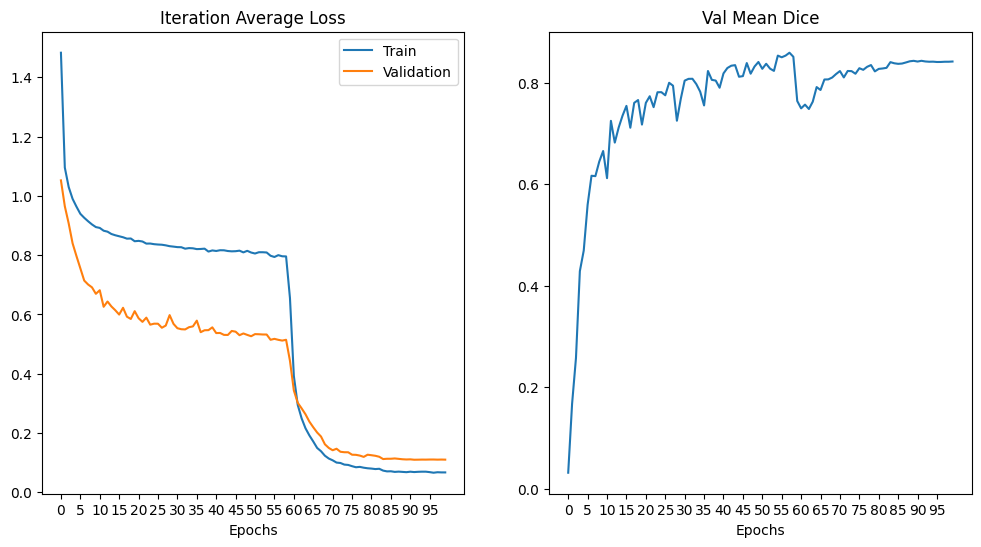

In [13]:
swin_trainer.plot_train_info()

In [9]:
file_list_test = generate_file_path(root_path=f'{root_dataset}/test', label_name=label_name)
test_ds = PersistentDataset(
    data=file_list_test,
    transform=val_transforms,
    cache_dir=f'test_{task_name}'
#     cache_dir='C:/Training/val'
)

test_loader = DataLoader(test_ds, num_workers=0, batch_size=1, 
                              collate_fn=lambda x: pad_list_data_collate(x, pad_to_shape=(96, 96, 96)))

In [10]:
torch.cuda.empty_cache()

In [11]:
swin_trainer.test_new(test_loader)

Test:   0%|                                                                                     | 0/64 [00:00<?, ?it/s]None of the inputs have requires_grad=True. Gradients will be None
invalid value encountered in double_scalars
torch.cuda.reset_max_memory_allocated now calls torch.cuda.reset_peak_memory_stats, which resets /all/ peak memory stats.
Test (loss=0.57653): 100%|█████████████████████████████████████████████████████████████| 64/64 [17:27<00:00, 16.36s/it]


([0.956514022303152,
  0.9611743890114326,
  0.9394159321252584,
  0.9241657111460356,
  0.9160224367797001,
  0.9217332768488612,
  0.9305778443295892,
  0.9025034208615613,
  0.880664055313452,
  0.8360969952771289,
  0.7662438514227742,
  0.782824890629511,
  0.8516953999830628,
  0.8654537854486324,
  0.917010885374695,
  0.9434189597787058,
  0.9469814700283887,
  0.9227148278368708,
  0.7699907779303209,
  0.8152961044228398,
  0.8970373029428657,
  0.8827964198988667,
  0.9475868113441093,
  0.9078537241506629],
 [3.0628794459533952,
  3.1193494418718264,
  10.493412035417586,
  16.015626151852956,
  19.603716441590016,
  19.27816780285183,
  12.401678917958982,
  15.969989930379299,
  19.00663194292533,
  19.79996449820242,
  28.446802732060274,
  24.97523962760514,
  13.536338638007662,
  18.8179682382138,
  13.101472076398753,
  6.965044198047613,
  3.1884613622912172,
  6.085817865402814,
  24.24482400697021,
  18.301440833246254,
  7.636596748960815,
  16.83280630620262,
  

In [11]:
torch.cuda.empty_cache()
swin_trainer.test_new(test_loader)

Test:   0%|                                                                                     | 0/64 [00:00<?, ?it/s]None of the inputs have requires_grad=True. Gradients will be None
invalid value encountered in double_scalars
torch.cuda.reset_max_memory_allocated now calls torch.cuda.reset_peak_memory_stats, which resets /all/ peak memory stats.
Test (loss=0.02071): 100%|█████████████████████████████████████████████████████████████| 64/64 [13:45<00:00, 12.89s/it]


([0.9550237772916683,
  0.9406493770830557,
  0.9348909634718879,
  0.9295861076743512,
  0.9540627829851608,
  0.9286871027601844,
  0.9330530328009146,
  0.9030768028300202,
  0.8677299290359319,
  0.8089367083418029,
  0.7962077974705921,
  0.7785867903454619,
  0.8512046415782425,
  0.8840324124932429,
  0.9149609604269017,
  0.9388387089291317,
  0.9410125030347284,
  0.9165504764721343,
  0.8209620679594722,
  0.8000572992497029,
  0.8381535669622356,
  0.9168570127708511,
  0.9404273078351598,
  0.8985169321575585],
 [2.986358297816274,
  13.58529545936771,
  12.506134687331564,
  15.359609242896152,
  9.026362630573706,
  16.829908825011465,
  11.721386881350398,
  15.766372752011604,
  20.646356223143886,
  24.99850067762424,
  24.56358755981359,
  25.575093827613927,
  15.215779135456897,
  15.77135175379608,
  13.17400106790927,
  6.764105894599649,
  2.7576639515978303,
  5.017237665344848,
  20.555457616537954,
  25.548419626931278,
  23.454668353135368,
  3.34235773521494

In [ ]:
for t in train_loader:
    if t['label'].max() == 0:
        print(t['label'].min(), t['label'].max() == 0)
    break